In [18]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mst
from scipy.interpolate import interp1d
from cycler import cycler
from lmfit import Parameters, minimize
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit


def load (initpath,datei,skip,separation):
    
    initpath= initpath +"/" + datei
    temp_df = np.array(pd.read_csv(initpath, comment='~', skiprows=skip, sep=separation,
                           encoding='latin1', header=None, on_bad_lines='skip',
                           decimal='.'))
    return temp_df
    
           
def read_datafiles(cellname):
    dataset = []
    testdata = {}
    eisdata = []
    fileVar = []
    celldata={}
    
    # initpath = r"C:\Users\Dominik\tubCloud\Arbeitsplatz\Skripte\Daten\Zahner"
    initpath= r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\EIS\Data"
    folderpath = initpath + "/" + cellname
    folders = os.listdir(folderpath)
    for folder in folders:
        path = folderpath + "/" + folder
        files = os.listdir(path)
        for file in (f for f in files if f.endswith("01.txt")):
            fileVar.append(file)
            with open(path + "/" + file, 'r') as f:
                lines = f.readlines()
                limits = [idx for idx, data in enumerate(lines) if 'Number' in data]
                data = lines[limits[0]+1:-1] 
                #Now, you can parse the lines into rows by splitting the line on whitespace
                rows = [line.split() for line in data]
                eisdata = np.array(rows, dtype=float)
            key = [p.split(".")[0] for p in file.split("_") if "mV" in p][0]
            testdata[key]=eisdata
            eisdata = []
        key_folder = folder.split("_", 2)[-1]  # z.B.→ '25grad'
        celldata[key_folder] = testdata
        testdata = {}
    #dataset.append(testdata)
    return celldata, folders, fileVar

def read_datafiles_neu(cellname):
    dataset = []
    eisdata = []
    fileVar = []
    celldata={}
    
    # initpath = r"C:\Users\Dominik\tubCloud\Arbeitsplatz\Skripte\Daten\Zahner"
    initpath= r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\EIS\Data"
    path = initpath + "/" + cellname
    files = os.listdir(path)
    for file in (f for f in files if f.endswith(".txt")):
        fileVar.append(file)
        with open(os.path.join(path, file), 'r') as f:
            lines = f.readlines()
            limits = [idx for idx, data in enumerate(lines) if 'Number' in data]
            data = lines[limits[0]+1:-1] 
            #Now, you can parse the lines into rows by splitting the line on whitespace
            rows = [line.split() for line in data]
            eisdata = np.array(rows, dtype=float)
        parts=file.replace(".txt", "").split("_")
        temp_key = parts[2]
        temp_key=temp_key.replace("deg","grad")  
        v=str(int(eisdata[5,6]*1000))+"mV"    
        if temp_key not in celldata:
            celldata[temp_key] = {}               
        celldata[temp_key][v] = np.flip(eisdata,axis=0)
        eisdata = []

    #dataset.append(testdata)
    return celldata, files, fileVar


def get_Voltagevalues(filenames):
    newName = []
    for i in range(len(filenames)):
        new = filesCell1[i].split(".")
        new = new[0][-6:]
        newName.append(new)
    #newName = newName[i][0]
    return newName  

def get_Voltagevalues60(filenames):
    newName = []
    for i in range(len(filenames)):
        new = filesCell3[i].split(".")
        new = new[0][-6:]
        newName.append(new)
    #newName = newName[i][0]
    return newName      

def getmOhm(data):
    newdata = data
    for i in range(len(data)):
        for j in range(len(data[i][0])):
            #data.append(dataCell1[0][2][i]*1000)
            newdata[i][2][j] = data[i][2][j] * 1000
            newdata[i][3][j] = data[i][3][j] * 1000
    return newdata

def interpFre(data):
    xq = np.arange(min(data[1]),max(data[1])+min(data[1]), 1)
    x = np.array(data[1], dtype=float)
    yre = data[2]
    yim = data[3]
    vqre = interp1d(x, yre)
    vqim = interp1d(x, yim)
    yintre = vqre(xq)
    yintim = vqim(xq)
    a = np.array([xq, yintre, yintim])

    b = min(yintim, key=abs)
    c = xq[np.where(yintim == b)]
    return c

def getFre(data):
    freIm = []
    for i in range(len(data)):
        minImInd = np.where(np.array(data[i][3]) == min(data[i][3], key=abs))[0]
        minImf = data[i][1][int(minImInd)]
        freIm.append(minImf)
    return freIm


In [2]:
from cycler import cycler
"""
Plot Farbeinstellungen
"""
plt.style.use('seaborn-v0_8')

default_cycler = (cycler(color=['#cc0000', '#22a15c', '#ff8000', '#00a6b3']))
plt.rc('lines', linewidth=1.5)
plt.rc('axes', prop_cycle=default_cycler)
plt.rcParams["figure.figsize"] = (9,7)
plt.rcParams["legend.fontsize"] = 18
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
fontsize = 20
labelsize=20

Daten einlesen

In [3]:
cellname = "60Ah_cell3_neu"
dataCell1, foldersCell1, filesCell1 = read_datafiles_neu(cellname)
temporär=dataCell1["25grad"]
data={}
#"46Ah_cell1", "46Ah_cell2","60Ah_cell1", "60Ah_cell3",
for i in ["46Ah_cell1", "46Ah_cell2","60Ah_cell1", "60Ah_cell3","60Ah_cell3_neu"]:
    if "neu" not in i:
        data[i], folders, files = read_datafiles(i)
    else:
        data[i], folders, files = read_datafiles_neu(i)
        for t in data[i].keys():
            sorted_keys=sorted(data[i][t].keys(), key=lambda x: int(x.replace("mV", "")))
            data[i][t] = {k: data[i][t][k] for k in sorted_keys}


    print(f"Data for {i}:")
    # print(data[i])
    print(data[i].keys())
    keys = list(data[i].keys())
    print(data[i][keys[0]].keys())


Data for 46Ah_cell1:
dict_keys(['25grad', '30grad', '35grad'])
dict_keys(['3553mV', '3698mV', '3941mV', '4200mV'])
Data for 46Ah_cell2:
dict_keys(['25grad', '30grad', '35grad'])
dict_keys(['3556mV', '3702mV', '3945mV', '4200mV'])
Data for 60Ah_cell1:
dict_keys(['messung1', 'messung2'])
dict_keys(['2700mV', '3350mV', '3410mV', '3460mV', '3505mV', '3540mV', '3566mV', '3587mV', '3610mV', '3625mV', '3650mV', '3680mV', '3720mV', '3770mV', '3822mV', '3830mV', '3880mV', '3935mV', '3990mV', '4050mV', '4110mV', '4200mV'])
Data for 60Ah_cell3:
dict_keys(['messung1'])
dict_keys(['2700mV', '3412mV', '3505mV', '3566mV', '3606mV', '3647mV', '3718mV', '3830mV', '3935mV', '4050mV', '4200mV'])
Data for 60Ah_cell3_neu:
dict_keys(['15grad', '25grad', '30grad', '35grad', '45grad'])
dict_keys(['3520mV', '3657mV', '3945mV', '4192mV'])


Plots pro Zelle

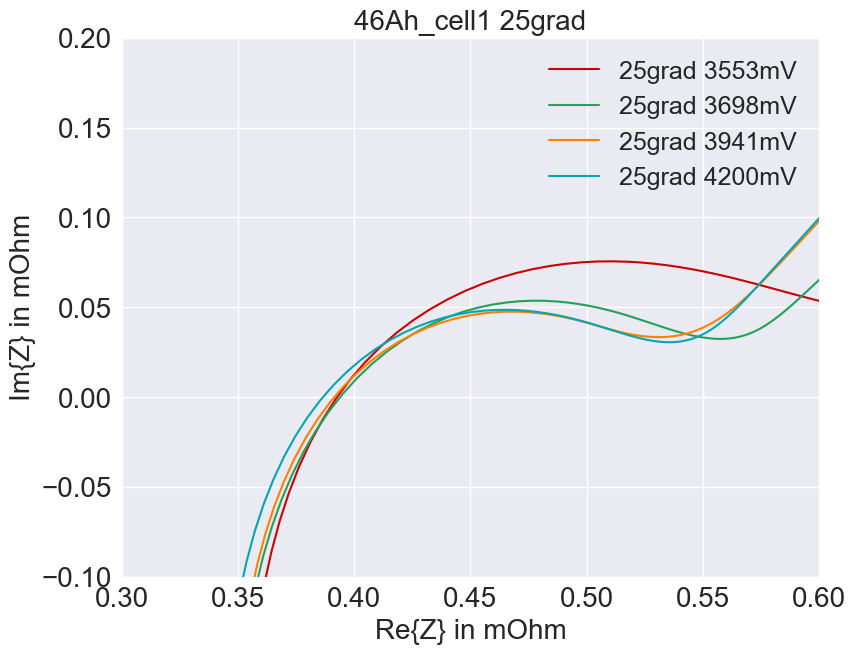

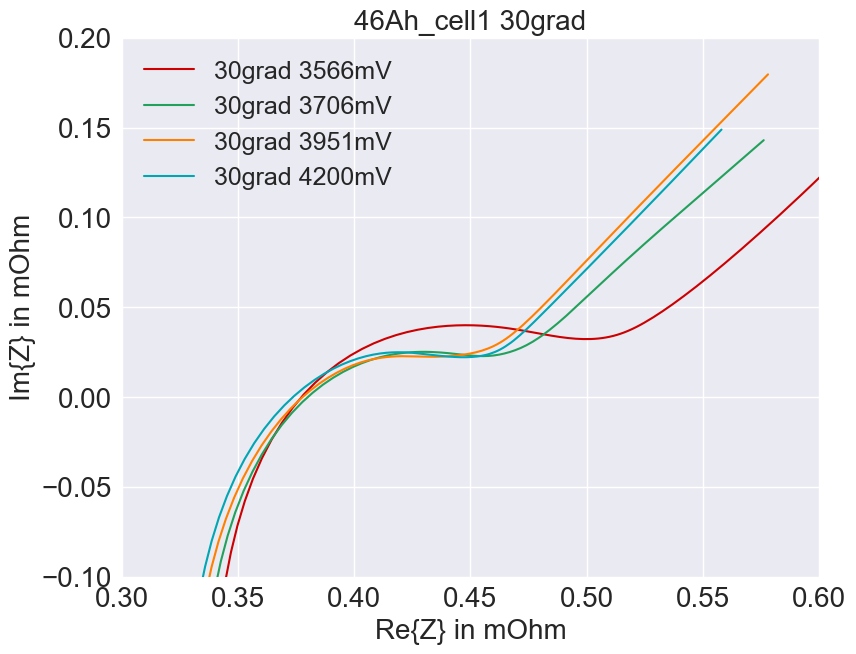

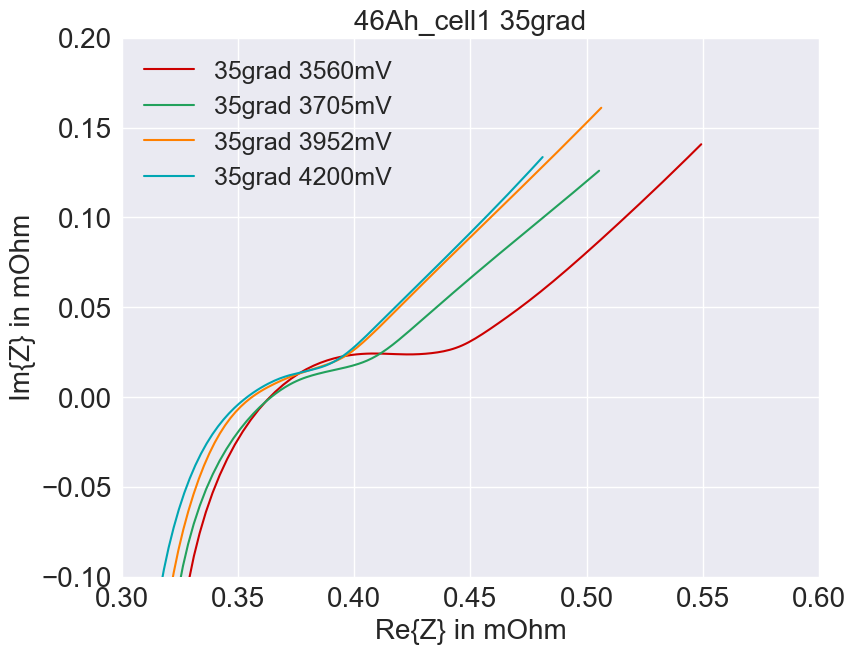

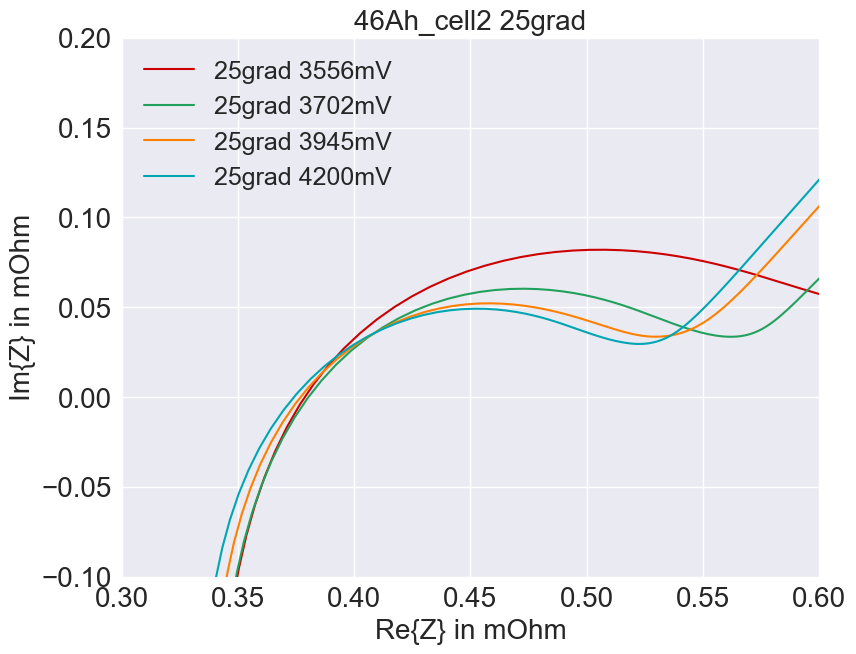

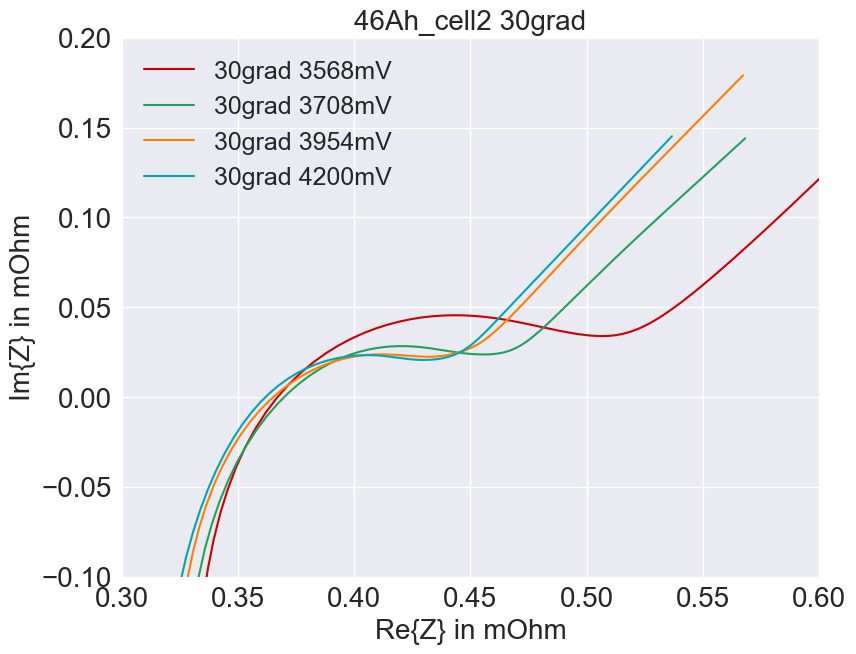

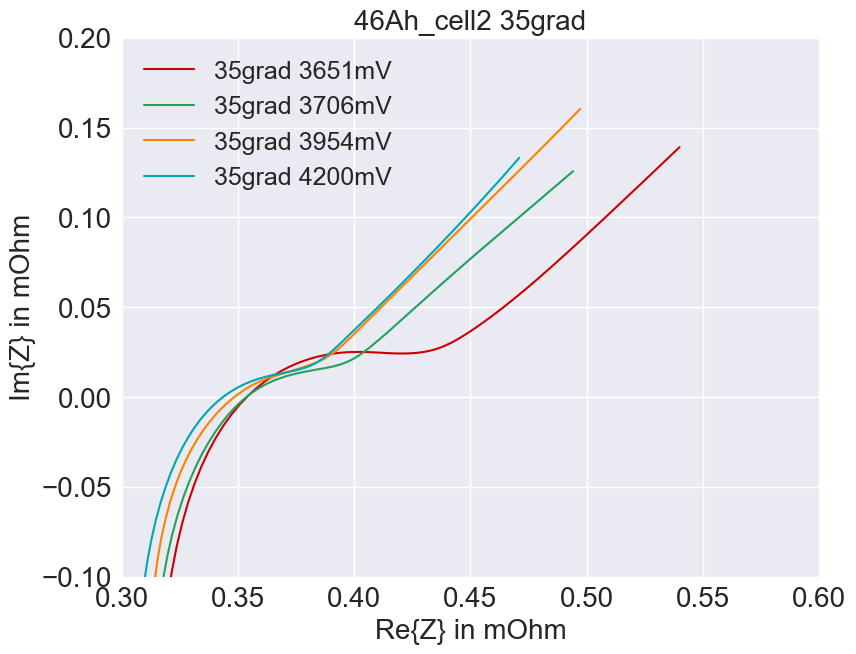

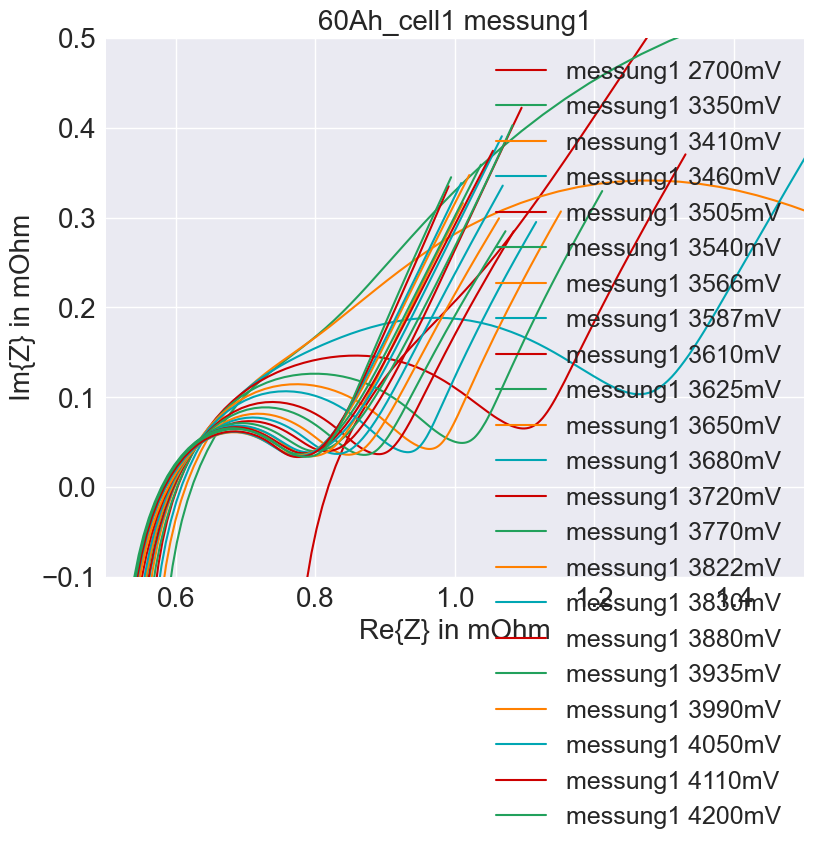

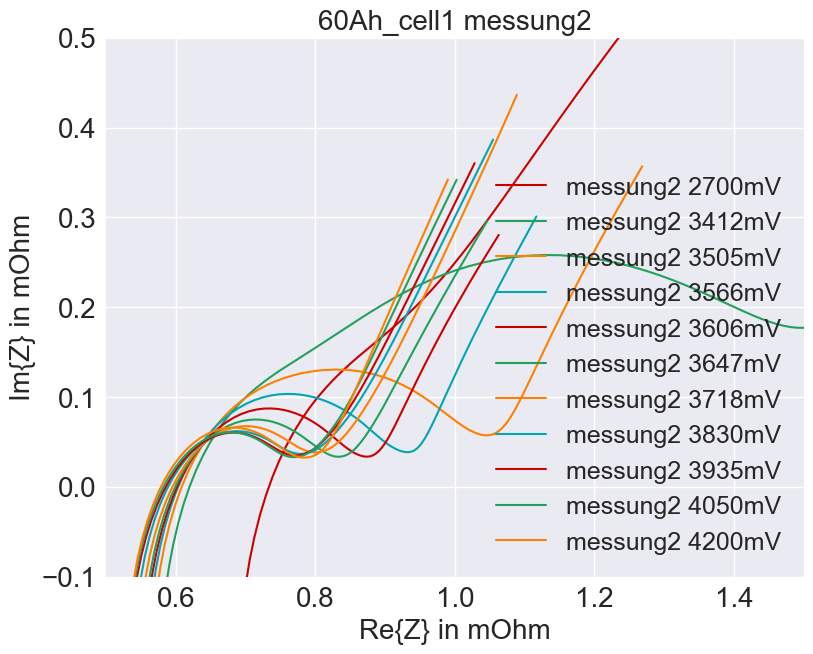

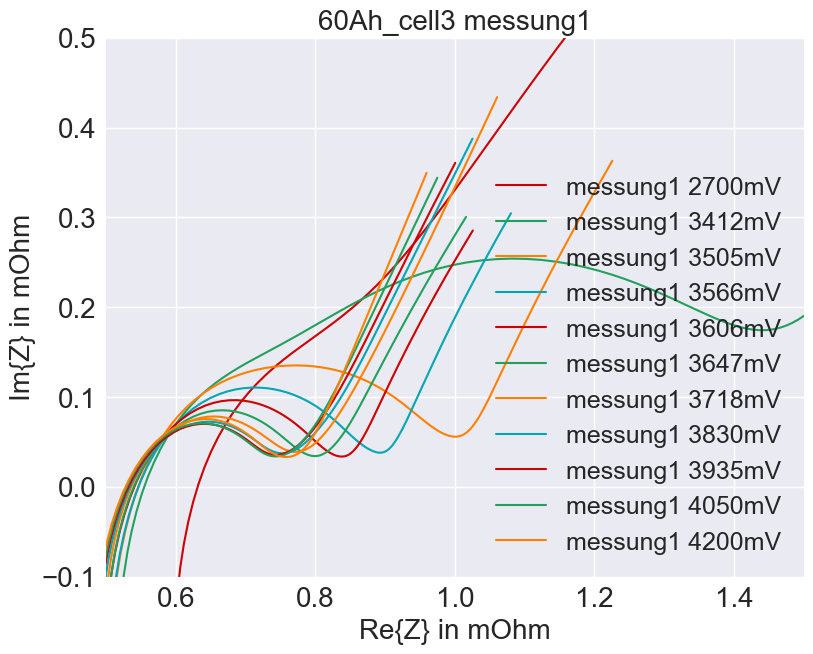

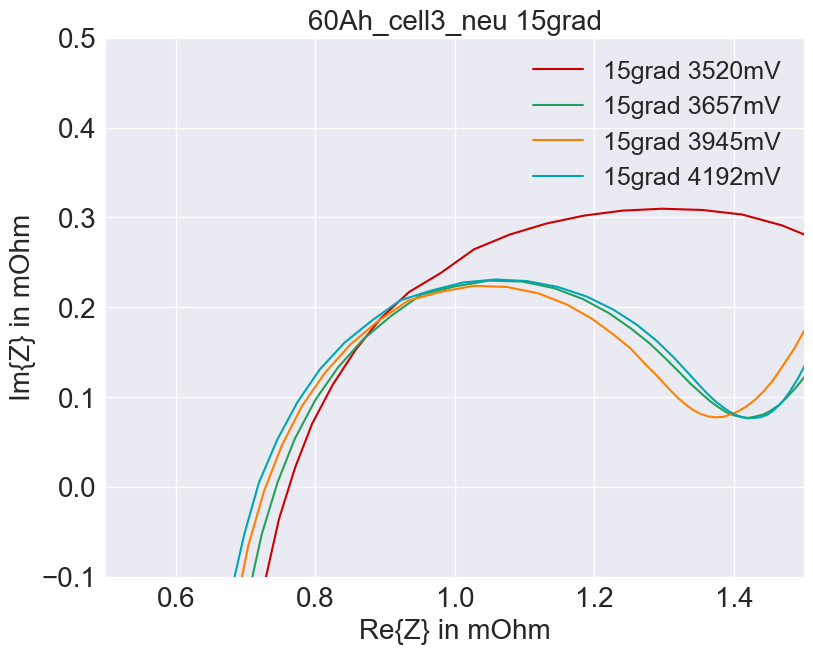

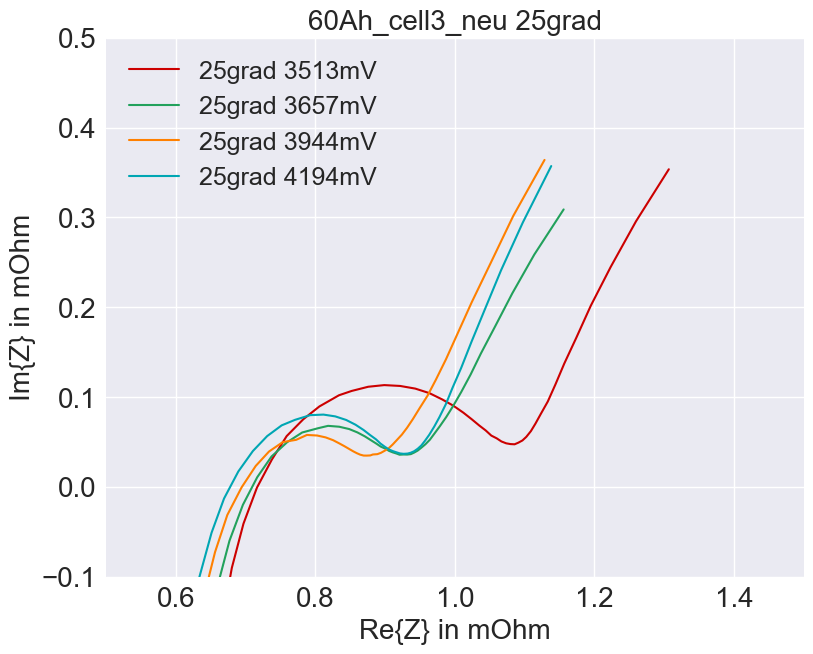

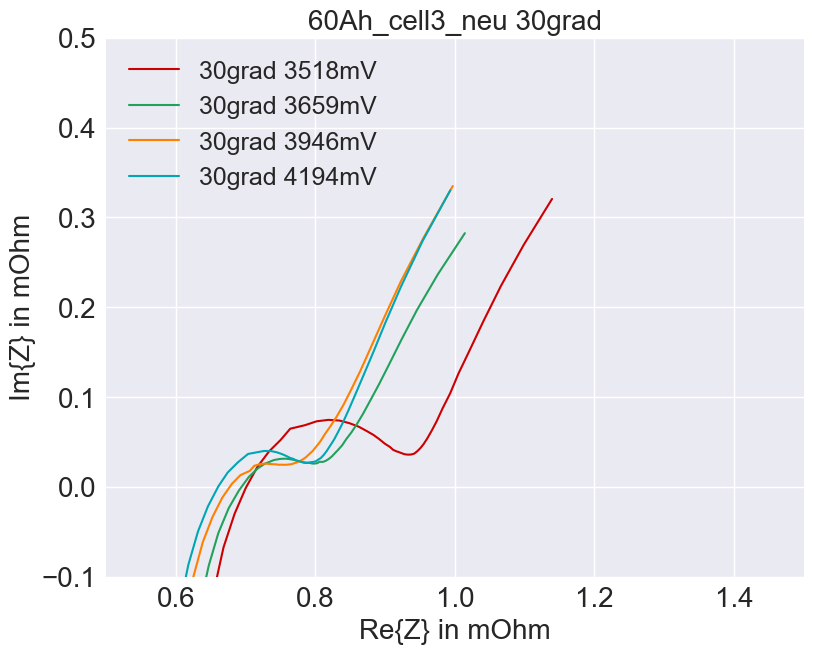

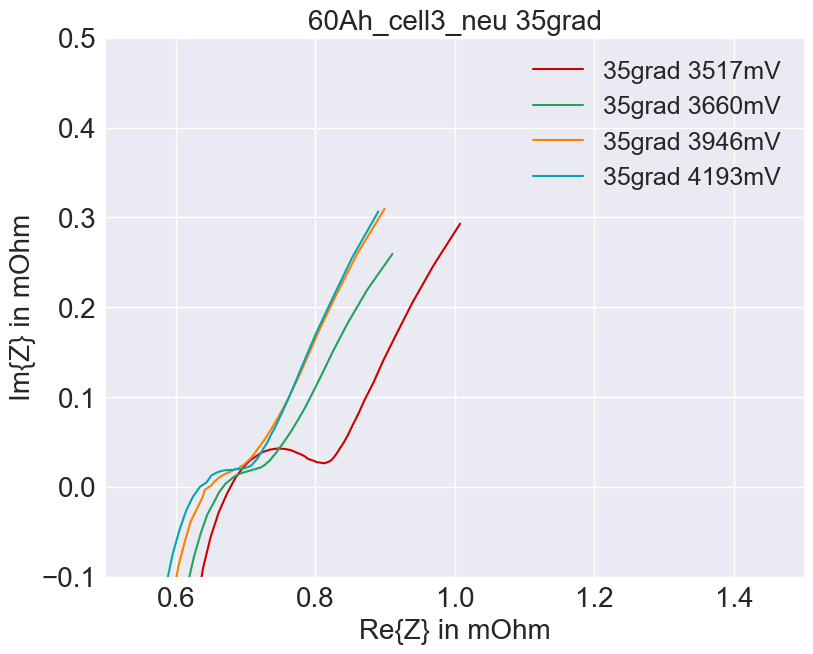

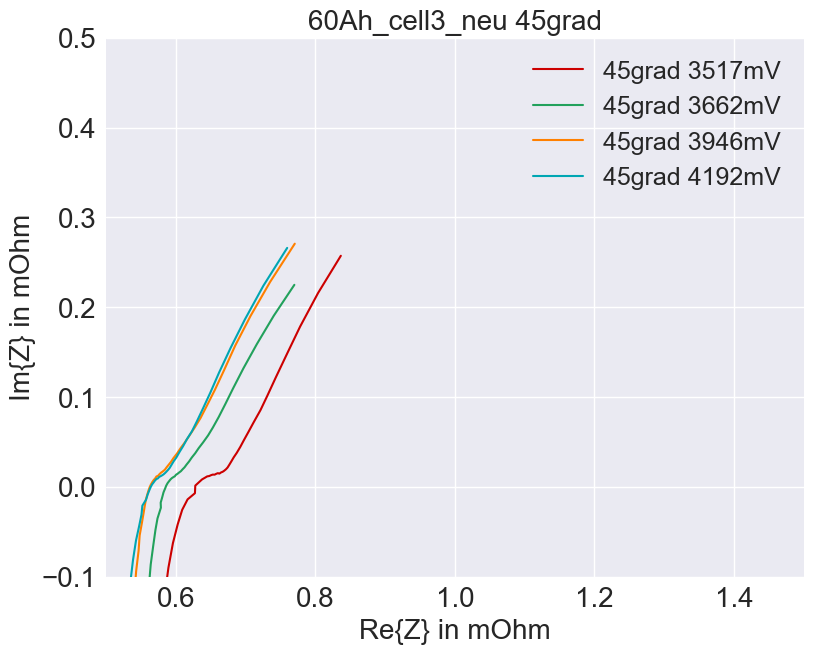

In [17]:
for cell in data.keys():
    for t in data[cell].keys():
        plt.figure()
 
        for i in data[cell][t].keys():
            plt.plot(data[cell][t][i][:,2]*1000, np.negative(data[cell][t][i][:,3])*1000, label=f"{t} {i}")
        plt.xlabel("Re{Z} in mOhm")
        plt.ylabel("Im{Z} in mOhm")
        if "60" in cell:
            plt.ylim(-0.1, 0.5)
            plt.xlim(0.5, 1.5)
        else:
            plt.ylim(-0.1, 0.2)
            plt.xlim(0.3, 0.6)
        plt.title(cell+" "+t)
        plt.legend()
        plt.show()

Vergleich 46Ah mit 60Ah über zuerst einen SOC und dann eine Temperatur

3698mV
3944mV


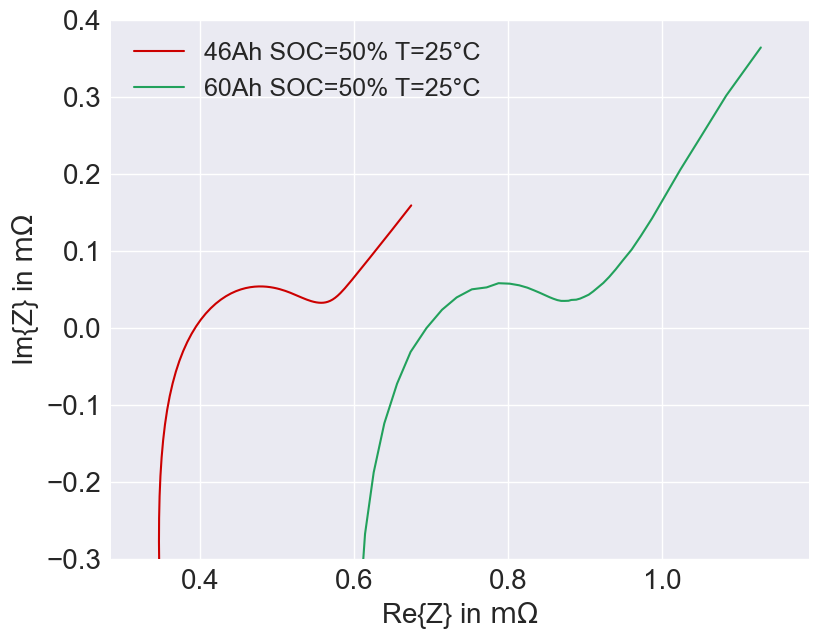

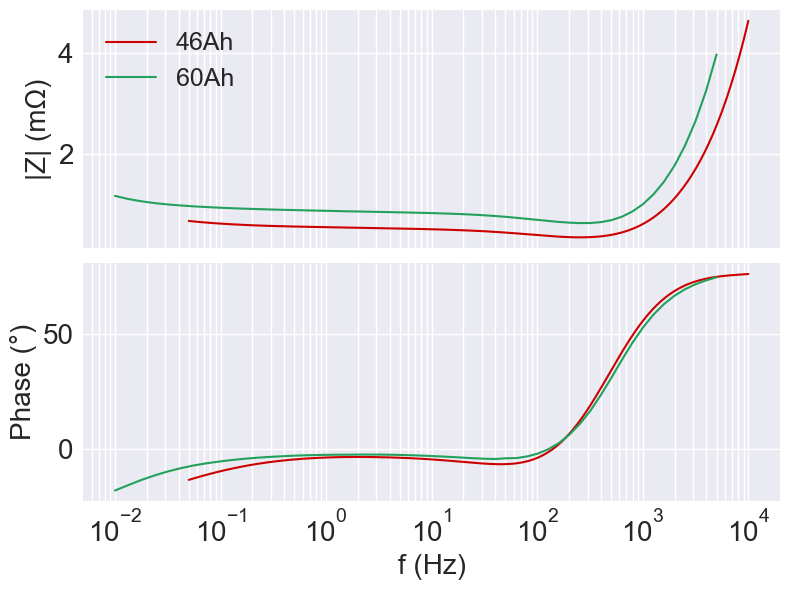

In [5]:
"""50% SOC und 25°C"""
plt.figure()
cell="46Ah_cell1"
t="25grad"
i=list(data[cell][t].keys())[1]
Z_46=data[cell][t][i][:,2]+1j*data[cell][t][i][:,3]
f_46=data[cell][t][i][:,1]
plt.plot(data[cell][t][i][:,2]*1000, np.negative(data[cell][t][i][:,3])*1000, label=cell.split("_")[0]+" SOC=50% T=25°C" )
print(i)
cell="60Ah_cell3_neu"
t="25grad"
i=list(data[cell][t].keys())[2]
Z_60=data[cell][t][i][:,2]+1j*data[cell][t][i][:,3]
f_60=data[cell][t][i][:,1]
plt.plot(data[cell][t][i][:,2]*1000, np.negative(data[cell][t][i][:,3])*1000, label=cell.split("_")[0]+" SOC=50% T=25°C" )
print(i)

plt.legend()
plt.xlabel("Re{Z} in $\mathrm{m}\Omega$")
plt.ylabel("Im{Z} in $\mathrm{m}\Omega$")
plt.axis('equal')
plt.ylim(-0.3,0.4)
plt.show()

# Betrag und Phase berechnen
mag_46 = np.abs(Z_46)
phase_46 = np.angle(Z_46, deg=True)  # Phase in Grad
mag_60 = np.abs(Z_60)
phase_60 = np.angle(Z_60, deg=True)

# Bode-Plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Betrag (log-log)
ax1.semilogx(f_46, mag_46*1000, label="46Ah")
ax1.semilogx(f_60, mag_60*1000, label="60Ah")
ax1.set_ylabel("|Z| (mΩ)")
ax1.legend()
ax1.grid(True, which="both")

# Phase
ax2.semilogx(f_46, phase_46, label="46Ah")
ax2.semilogx(f_60, phase_60, label="60Ah")
ax2.set_xlabel("f (Hz)")
ax2.set_ylabel("Phase (°)")
ax2.grid(True, which="both")

plt.tight_layout()
plt.show()



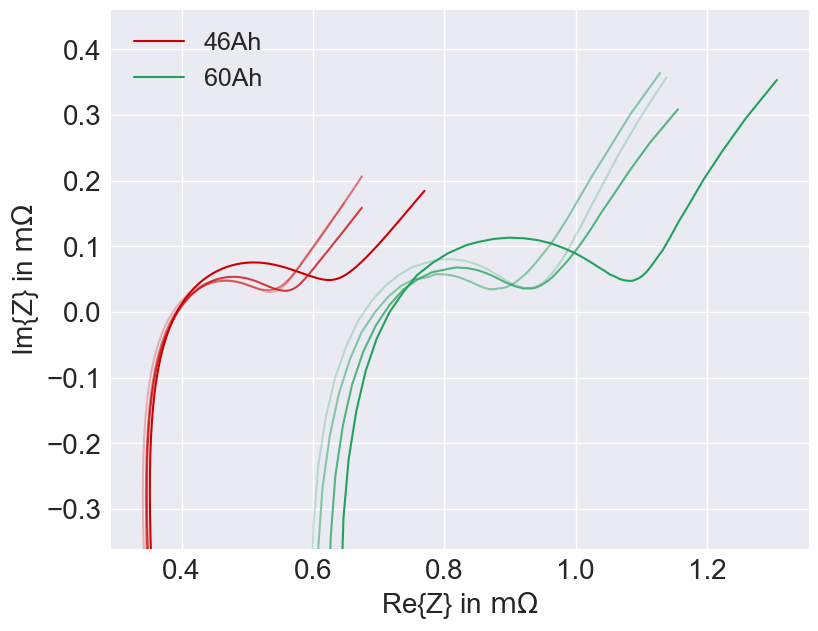

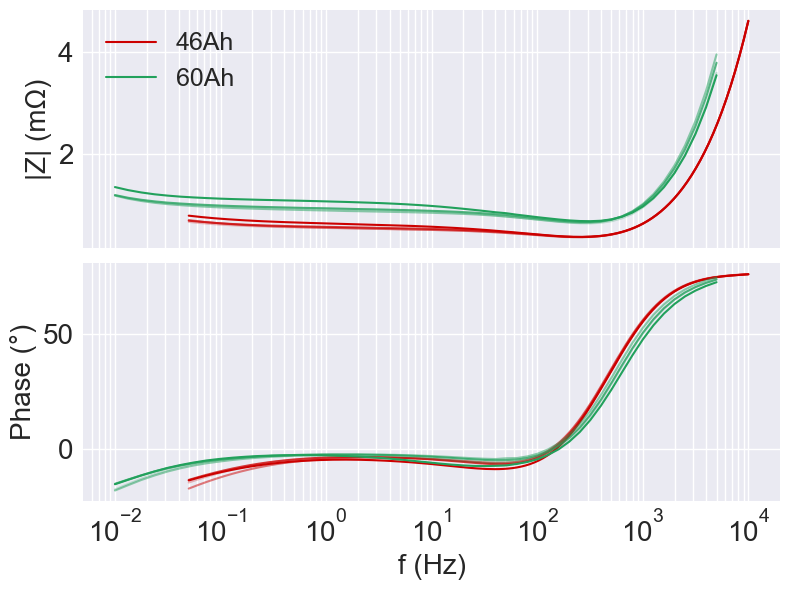

In [6]:

"""über Temperatur 25°C"""
plt.figure()
colors=['#cc0000', '#22a15c']
c=0
for cell in ["46Ah_cell1","60Ah_cell3_neu"]:
    t="25grad"
    zähler=0
    anzahl=len(list(data[cell][t].keys()))
    for i in data[cell][t].keys():
        a=1-zähler/anzahl
        if zähler==0:
            label=cell.split("_")[0]
        else: label=None
        
        plt.plot(data[cell][t][i][:,2]*1000, np.negative(data[cell][t][i][:,3])*1000, label=label,alpha=a,color=colors[c])
        zähler += 1
    c+=1
plt.xlabel("Re{Z} in $\mathrm{m}\Omega$")
plt.ylabel("Im{Z} in $\mathrm{m}\Omega$")
plt.axis('equal')
plt.ylim(-0.3,0.4)
plt.legend()
plt.show()


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
colors=['#cc0000', '#22a15c']
c=0
for cell in ["46Ah_cell1","60Ah_cell3_neu"]:
    t="25grad"
    zähler=0
    anzahl=len(list(data[cell][t].keys()))
    for i in data[cell][t].keys():
        a=1-zähler/anzahl
        if zähler==0:
            label=cell.split("_")[0]
        else: label=None
        Z=data[cell][t][i][:,2]+1j*data[cell][t][i][:,3]
        f=data[cell][t][i][:,1]
        mag = np.abs(Z)
        phase= np.angle(Z, deg=True)  
        #Betrag
        ax1.semilogx(f, mag*1000, label=label, alpha=a, color=colors[c])
        

        # Phase
        ax2.semilogx(f, phase, label=label, alpha=a, color=colors[c])
        
        zähler += 1
    c+=1
ax1.set_ylabel("|Z| (mΩ)")
ax1.legend()
ax1.grid(True, which="both")
ax2.set_xlabel("f (Hz)")
ax2.set_ylabel("Phase (°)")
ax2.grid(True, which="both")
plt.tight_layout()
plt.show()


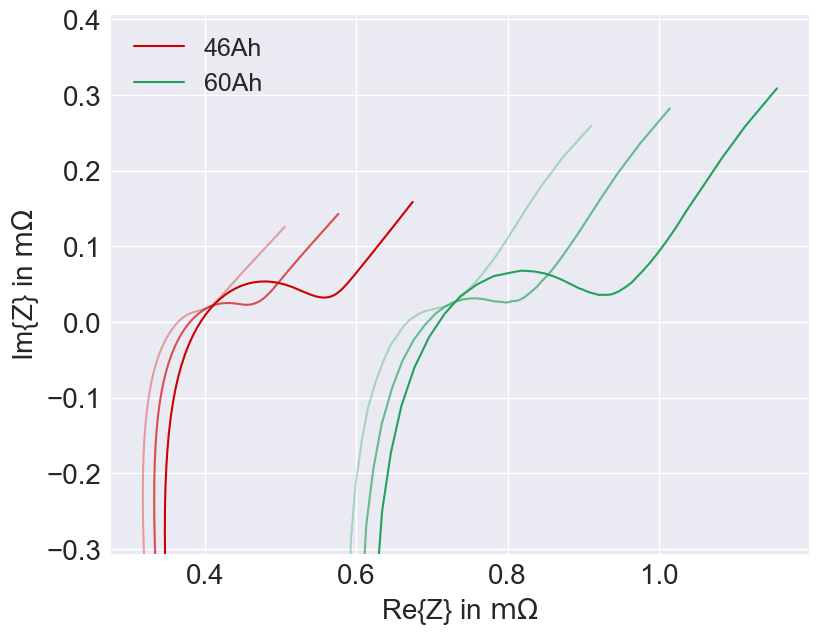

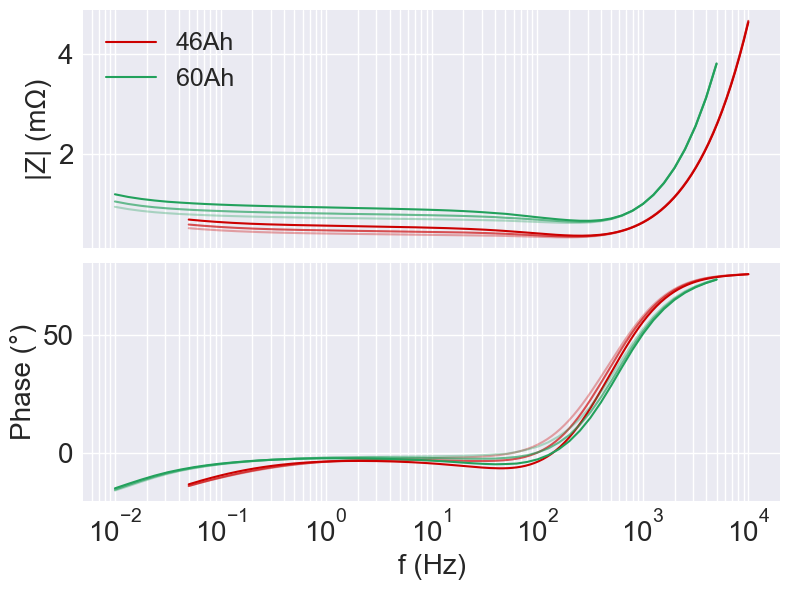

In [7]:

"""SOC=50%"""
plt.figure()
colors=['#cc0000', '#22a15c']
c=0
for cell in ["46Ah_cell1","60Ah_cell3_neu"]:
    zähler=0
    anzahl=len(list(data[cell].keys()))
    for t in data[cell].keys():
        anzahl=3
        i=list(data[cell][t].keys())[-3]
        a=1-zähler/anzahl
        if zähler==0:
            label=cell.split("_")[0]
        else: label=None
        if "25" in t or "30" in t or "35" in t:
            plt.plot(data[cell][t][i][:,2]*1000, np.negative(data[cell][t][i][:,3])*1000, label=label,alpha=a,color=colors[c])
            zähler += 1
    c+=1
plt.xlabel("Re{Z} in $\mathrm{m}\Omega$")
plt.ylabel("Im{Z} in $\mathrm{m}\Omega$")
plt.axis('equal')
plt.ylim(-0.3,0.4)
plt.legend()
plt.show()


#Bode

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
colors=['#cc0000', '#22a15c']
c=0
for cell in ["46Ah_cell1","60Ah_cell3_neu"]:
    zähler=0
    anzahl=len(list(data[cell].keys()))
    for t in data[cell].keys():
        anzahl=3
        i=list(data[cell][t].keys())[-3]
        a=1-zähler/anzahl
        if zähler==0:
            label=cell.split("_")[0]
        else: label=None

        Z=data[cell][t][i][:,2]+1j*data[cell][t][i][:,3]
        f=data[cell][t][i][:,1]
        mag = np.abs(Z)
        phase= np.angle(Z, deg=True)
        
        if "25" in t or "30" in t or "35" in t:
            # Betrag
            ax1.semilogx(f, mag*1000, label=label, alpha=a, color=colors[c])
            # Phase
            ax2.semilogx(f, phase, label=label, alpha=a, color=colors[c])
            zähler += 1
        else: pass
    c+=1
ax1.set_ylabel("|Z| (mΩ)")
ax1.legend()
ax1.grid(True, which="both")
ax2.set_xlabel("f (Hz)")
ax2.set_ylabel("Phase (°)")
ax2.grid(True, which="both")
plt.tight_layout()
plt.show()



1. Basierend auf der Impedanzspektrumsanalyse und der visuellen Interpretation des Nyquist-Diagramms wird das elektrochemische System durch folgende Ersatzschaltung modelliert:

\begin{equation}
Z(j\omega) = R_0 + j\omega L_0 + 
\underbrace{\frac{R_1}{1 + (j\omega A_1)^{p_1}}}_{\text{ZARC}_1} +
\underbrace{\frac{R_2}{1 + (j\omega A_3)^{p_2}}}_{\text{ZARC}_2} +
\underbrace{A_2 (j\omega)^{-1/2}}_{\text{Warburg}}
\end{equation}

R0 ------ Ohmscher Serienwiderstand

L0 ------ Induktivität

ZARC1 ZARC2 ----- Der ZARC besteht aus einem phasenkonstanten Element (CPE), das parallel zu einem Widerstand R

Warburg element ------Diffusionskontrollierter Prozess

2. Fehlerfunktion (Residual) definieren:

   \begin{equation}
   \text{residual} = \Re(Z_{\text{modell}} - Z_{\text{exp}}) \, \Vert \, \Im(Z_{\text{modell}} - Z_{\text{exp}})
   \end{equation}

Der Residualvektor setzt sich aus dem Real- und Imaginärteil der Differenz zusammen.(mittels np.concatenate() )

3. lmfit.minimize führt die Anpassung durch und gibt die optimierten Parameter aus.


In [39]:
# Enthält zwei ZARCs und einen Warburg.
def Z_model(params, omega):
    R0 = params['R0']
    L0 = params['L0']
    RL = params['RL']  
    R1 = params['R1']
    A1 = params['A1']
    p1 = params['p1']
    R2 = params['R2']
    A3 = params['A3']
    p2 = params['p2']
    R3 = params['R3']
    A4 = params['A4']
    p3 = params['p3']
    A2 = params['A2'] 

    jw = 1j * omega
    Z_L = (RL * jw * L0) / (RL + jw * L0)
    Z_ZARC1 = R1 / (1 + (jw * A1)**p1)
    Z_ZARC2 = R2 / (1 + (jw * A3)**p2)
    Z_ZARC3 = R3 / (1 + (jw * A4)**p3)
    Z_W = A2 * (jw ** -0.5)

    Z_total = R0 + Z_L + Z_ZARC1 + Z_ZARC2 +Z_W
    return Z_total
# Residual definieren
def residual(params, omega, data):
    model = Z_model(params, omega)
    return np.concatenate([(model.real - data.real), (model.imag - data.imag)])




fit_data = {}
plot_data={}
min_idx=0
# for cell in []:
for cell in ["46Ah_cell1", "46Ah_cell2","60Ah_cell3_neu"]:
    fit_data[cell] = {}
    plot_data[cell] = {}
    for t in data[cell].keys():
        plot_data[cell][t] = {}
        print("\n"+cell+" "+t+":\n")
        results_list = []
        for i in data[cell][t].keys():
                        
            test=data[cell][t][i]
            frequencies = test[:,1]  # Hz
            if "60Ah" in cell:
                max_freq=np.where(frequencies>1000)[0][0]
                min_freq=np.where(frequencies<0.018)[0][-1]
            else:
                max_freq=np.where(frequencies>800)[0][0]
                min_freq=np.where(frequencies<0.08)[0][-1]
            # print(max_freq)
            # print(min_freq)

            # Frequenz in Kreisfrequenz umrechnen
            frequencies = test[min_freq:max_freq,1]  # Hz
            omega = 2 * np.pi * frequencies
            # Messdaten als komplexe Impedanz interpretieren
            Z_real = test[min_freq:max_freq,2]
            Z_imag = test[min_freq:max_freq,3]
            Z_exp = Z_real + 1j * Z_imag


            #---
            #Prefit
            #---
            # Anfangsparameter
            params_pre = Parameters()
            params_pre.add('R0', value=0.05, min=0)
            params_pre.add('L0', value=1e-6, min=0)
            params_pre.add('RL', value=0.1, min=0)
            params_pre.add('R1', value=0.1, min=0)
            params_pre.add('A1', value=1e-3, min=1e-6)
            params_pre.add('p1', value=0.9, min=0.5, max=1)
            params_pre.add('R2', value=0.05, min=0)
            params_pre.add('A3', value=1e-2, min=1e-6)
            params_pre.add('p2', value=0.8, min=0.5, max=1)
            params_pre.add('A2', value=1e-3, min=1e-6)
            params_pre.add('R3', value=0.05, min=0)
            params_pre.add('A4', value=1e-3, min=1e-6)
            params_pre.add('p3', value=0.8, min=0.5, max=1)

            # wichtig ist Standardfehler
            result_pre = minimize(residual, params_pre, args=(omega, Z_exp))
            # print("\n Prefit: \n")
            # result_pre.params.pretty_print()
            #Berechnung der Modellimpedanz für gegebene Frequenzen mit den optimierten Parametern.
            Z_fit_pre = Z_model(result_pre.params, omega)

            #---
            # Fit
            #---
            # Anfangsparameter aus Prefit
            params = Parameters()
            params.add('R0', value=result_pre.params['R0'].value, min=0)
            params.add('L0', value=result_pre.params['L0'].value, min=0)
            params.add('RL', value=result_pre.params['RL'].value, min=0)
            params.add('R1', value=result_pre.params['R1'].value, min=0)
            params.add('A1', value=result_pre.params['A1'].value, min=1e-6)
            params.add('p1', value=result_pre.params['p1'].value, min=0.5, max=1)
            params.add('R2', value=result_pre.params['R2'].value, min=0)
            params.add('A3', value=result_pre.params['A3'].value, min=1e-6)
            params.add('p2', value=result_pre.params['p2'].value, min=0.5, max=1)
            params.add('A2', value=result_pre.params['A2'].value, min=1e-6)
            params.add('R3', value=result_pre.params['R3'].value, min=0)
            params.add('A4', value=result_pre.params['A4'].value, min=1e-6)
            params.add('p3', value=result_pre.params['p3'].value, min=0.5, max=1)

            result = minimize(residual, params, args=(omega, Z_exp))
            # print("\n Fit: \n")
            # result.params.pretty_print()
            Z_fit = Z_model(result.params, omega)
            plot_data[cell][t][i] = Z_fit

            param_values = {name: param.value for name, param in result.params.items()}
            param_values["U"] = float(i.replace("mV", "")) / 1000
            if t=="25grad":
                min_idx = argrelextrema(-Z_imag, np.less)[0]
                if len(min_idx) == 0:  # Fallback auf globales Minimum
                    min_idx = np.argmin(Z_imag)
                else:
                    min_idx = min_idx[0]
            else:
                # min_idx=min_idx
                min_idx=argrelextrema(-Z_imag, np.less)[0]
                if len(min_idx) == 0:  # Fallback auf globales Minimum
                    min_idx = np.argmin(Z_imag)
                else:
                    min_idx = min_idx[0]
            param_values["Rmin"]=Z_real[min_idx]
            results_list.append(param_values)
            
            print(i + " fertig")
        # Alles in einen DataFrame
        df = pd.DataFrame(results_list)

        # Optional: Spannung als Index setzen
        df.set_index("U", inplace=True)

        print(df)
        fit_data[cell][t] = df
        min_idx=0

# plt.figure()
# plt.plot(Z_exp.real*1000, -Z_exp.imag*1000, 'o', label='Measured')
# plt.plot(Z_fit.real*1000, -Z_fit.imag*1000, '-', label='Fitted')
# plt.xlabel("Z' (Ohm)")
# plt.ylabel("-Z'' (Ohm)")
# plt.axis("equal")
# plt.title("Nyquist Plot")
# if "60Ah" in cell:
#     plt.ylim(-0.1, 0.5)
#     plt.xlim(0.5, 1.5)
# else:
#     plt.ylim(-0.1, 0.2)
#     plt.xlim(0.3, 0.6)
# plt.legend()
# plt.grid(True)


46Ah_cell1 25grad:

3553mV fertig
3698mV fertig
3941mV fertig
4200mV fertig
             R0            L0        RL        R1        A1        p1  \
U                                                                       
3.553  0.000326  8.775189e-08  0.012073  0.000231  0.002273  0.830202   
3.698  0.000316  8.809215e-08  0.011325  0.000222  0.002012  0.799072   
3.941  0.000321  8.798015e-08  0.011837  0.000190  0.001930  0.839568   
4.200  0.000326  8.570383e-08  0.017097  0.000148  0.001598  0.936412   

                 R2        A3        p2        A2    R3     A4   p3      Rmin  
U                                                                              
3.553  4.437862e-05  0.018603  0.920397  0.000137  0.05  0.001  0.8  0.000625  
3.698  1.436851e-12  0.011016  0.600808  0.000111  0.05  0.001  0.8  0.000557  
3.941  3.743672e-13  0.000281  0.629932  0.000139  0.05  0.001  0.8  0.000530  
4.200  3.847816e-05  0.008769  1.000000  0.000113  0.05  0.001  0.8  0.000535  

46A

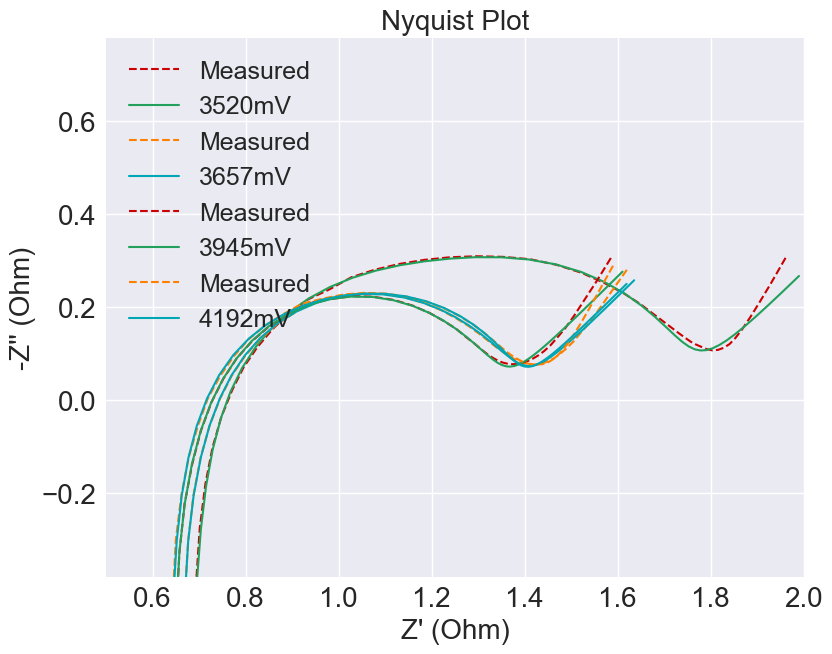

In [9]:
plt.figure()
cell = "60Ah_cell3_neu"
temperature = "15grad"
# voltage = "4194mV"

# min_freq=2
# max_freq=102
# Z_real = data[cell][temperature][voltage][min_freq:max_freq,2]
# Z_imag = data[cell][temperature][voltage][min_freq:max_freq,3]
# Z_exp = Z_real + 1j * Z_imag
# Z_fit= plot_data[cell][temperature][voltage]
# plt.plot(Z_exp.real*1000, -Z_exp.imag*1000, 'o', label='Measured')
# plt.plot(Z_fit.real*1000, -Z_fit.imag*1000, '-', label=voltage)

for voltage in data[cell][temperature].keys():
    min_freq=2
    max_freq=102
    Z_real = data[cell][temperature][voltage][min_freq:max_freq,2]
    Z_imag = data[cell][temperature][voltage][min_freq:max_freq,3]
    Z_exp = Z_real + 1j * Z_imag
    Z_fit= plot_data[cell][temperature][voltage]
    plt.plot(Z_exp.real*1000, -Z_exp.imag*1000, '--', label='Measured')
    plt.plot(Z_fit.real*1000, -Z_fit.imag*1000, '-', label=voltage)
plt.xlabel("Z' (Ohm)")
plt.ylabel("-Z'' (Ohm)")
plt.axis("equal")
plt.title("Nyquist Plot")
if "60Ah" in cell:
    plt.ylim(-0.1, 0.5)
    plt.xlim(0.5, 2)
else:
    plt.ylim(-0.1, 0.2)
    plt.xlim(0.3, 0.6)
plt.legend()
plt.grid(True)

Aktivierungsenergie

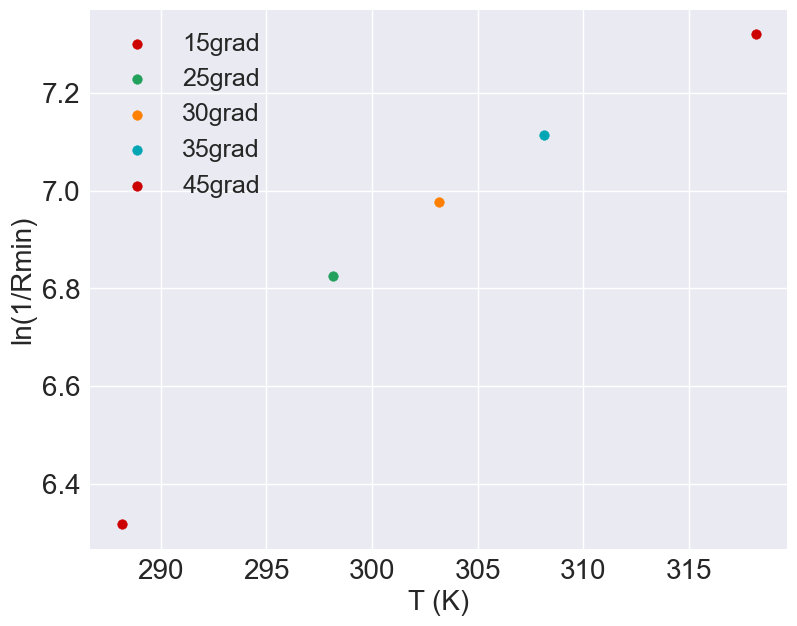

In [40]:
plt.figure()
cell = "60Ah_cell3_neu"
cell2= "46Ah_cell1"

x=0
element="Rmin"
for t in data[cell].keys():
    temperatur = int(t.replace("grad", ""))+273.15
    # plt.scatter(1000*1/temperatur,np.log(1/fit_data[cell][t][element].iloc[x]))
    plt.scatter(temperatur,np.log(1/fit_data[cell][t][element].iloc[x]),label=t)
for t in data[cell2].keys():
    temperatur = int(t.replace("grad", ""))+273.15
    # plt.scatter(1000*1/temperatur,np.log(1/fit_data[cell][t][element].iloc[x]))
    # plt.scatter(temperatur,np.log(1/fit_data[cell2][t][element].iloc[x]),label=t)

plt.xlabel("T (K)")
plt.ylabel("ln(1/"+element+")")
# plt.yscale("log", base=np.e)
plt.legend()
plt.grid(True)


16991.902417125744 13.807979182466712 992496.9142461017


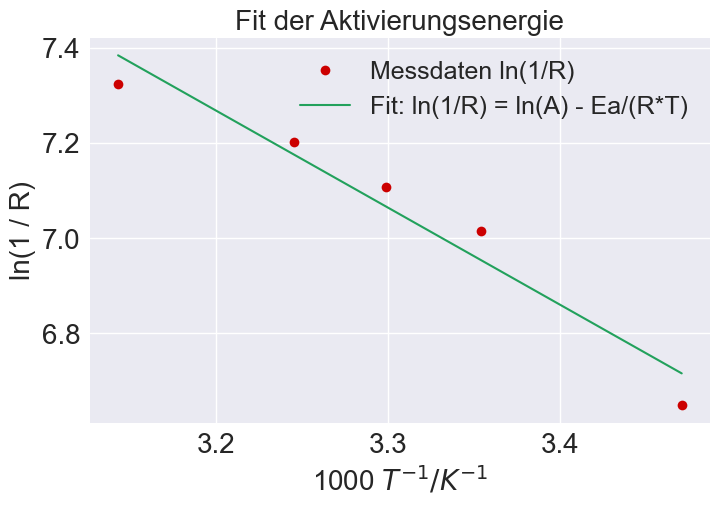

1091.6144893213184


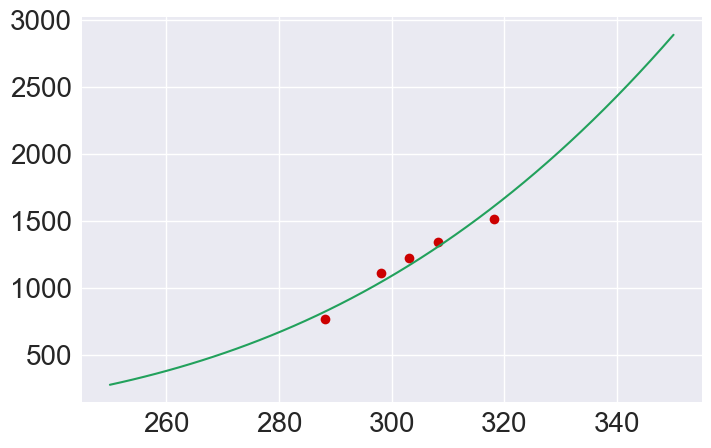

In [11]:
from scipy.optimize import minimize as scipy_minimize
R_g = 8.314 
cell = "60Ah_cell3_neu"

i=0
element="Rmin"
temperatur=[]
R_values=[]
for t in data[cell].keys():
    temperatur.append(int(t.replace("grad", ""))+273.15)
    R_values.append(fit_data[cell][t][element].iloc[i])
    # plt.scatter(1000*1/temperatur,1/fit_data[cell][t][element].iloc[x],label=t)
R_values=np.array(R_values)
temperatur=np.array(temperatur)
x=temperatur
y=np.log(1/R_values)

def fitfunc(params):
    Ea, lnA = params
    model = lnA - Ea /(R_g * x)
    return np.sum((y - model)**2)


start_params = [10000, 3000]  # Ea in J/mol, lnA beliebig

result = scipy_minimize(fitfunc, start_params)
Ea_fit, lnA_fit = result.x
A_fit= np.exp(lnA_fit)

print(Ea_fit,lnA_fit,A_fit)

x_fit = np.linspace(min(x), max(x), 200)
y_fit = lnA_fit - Ea_fit / (R_g * x_fit)

# Plot
plt.figure(figsize=(8,5))
plt.plot(1000/x,y, 'o', label='Messdaten ln(1/R)')
plt.plot(1000/x_fit, y_fit, '-', label='Fit: ln(1/R) = ln(A) - Ea/(R*T)')
plt.xlabel('1000 $ T^{-1}/K^{-1}$')
plt.ylabel('ln(1 / R)')
plt.legend()
plt.title('Fit der Aktivierungsenergie')
plt.grid(True)
plt.show()
plt.figure(figsize=(8,5))
x_fit=np.linspace(250,350)
plt.plot(x,np.exp(y), 'o', label='Messdaten 1/R')
plt.plot(x_fit,A_fit*np.exp(-Ea_fit/(R_g*x_fit)))
print(A_fit*np.exp(-Ea_fit/(R_g*300)))
plt.grid(True)
plt.show()

Aktivierungsenergie andere Variante

In [38]:
from scipy.signal import argrelextrema
cell = "60Ah_cell3_neu"
t="45grad"
i=list(data[cell][t].keys())[1]
testdata=data[cell][t][i]

# Beispiel: Spalte 0 = Frequenz, Spalte 2 = Imaginärteil
freq = testdata[:, 0]
Z_imag = testdata[:, 2]

# Lokale Minima im Imaginärteil
min_idx = argrelextrema(-Z_imag, np.less)[0]

if len(min_idx) > 0:
    for idx in min_idx:
        print(f"Lokales Minimum: Z'' = {Z_imag[idx]} bei f = {freq[idx]} Hz")
else:
    print("Kein lokales Minimum gefunden")

Lokales Minimum: Z'' = 0.00057846 bei f = 21.0 Hz


signifikante Punkte speichern

In [102]:
def linear_func(x,m,b):
    return m*x+b
 
save_data={}
for cell in data.keys():
    save_data[cell] = {}

    for t in data[cell].keys():
        print("\n"+cell+" "+t+":\n")
        results_list = []
        for i in data[cell][t].keys():
                        
            test=data[cell][t][i]
            frequencies = test[:,1]  # Hz

            Z_real = test[:,2]
            Z_imag = test[:,3]
            Z_exp = Z_real + 1j * Z_imag


            values = {}
            values["U"] = float(i.replace("mV", "")) / 1000

            min_idx_temp = argrelextrema(-Z_imag, np.less)[0]
            if len(min_idx_temp) == 0:  # Fallback auf globales Minimum
                pass
            else:
                min_idx = min_idx_temp[0]
                values["Rmin"]=Z_real[min_idx]

            
            idx_0=np.argmin(np.abs(Z_imag))
            values["R0"]=Z_real[idx_0]
            print(frequencies[min_idx],min_idx)
            if(len(min_idx_temp)!=0):
                params, cov = curve_fit(linear_func, Z_real[:int(min_idx/2)], Z_imag[:int(min_idx/2)]) #damit nur der lineare ast
                m, b = params
                values["m"]=m
                values["b"]=b
            print(i + " fertig")
            results_list.append(values)

        # Alles in einen DataFrame
        df = pd.DataFrame(results_list)

        # Optional: Spannung als Index setzen
        # df.set_index("U", inplace=True)

        print(df)
        save_data[cell][t] = df
        min_idx=0


46Ah_cell1 25grad:

1.7033 37
3553mV fertig
2.2675 40
3698mV fertig
3.6527 45
3941mV fertig
2.4943 41
4200mV fertig
       U      Rmin        R0         m         b
0  3.553  0.000625  0.000392 -1.140917  0.000695
1  3.698  0.000557  0.000395 -1.253148  0.000687
2  3.941  0.000530  0.000390 -1.433677  0.000762
3  4.200  0.000535  0.000385 -1.412448  0.000748

46Ah_cell1 30grad:

3.0185 43
3566mV fertig
5.349 49
3706mV fertig
11.471 57
3951mV fertig
4.8625 48
4200mV fertig
       U      Rmin        R0         m         b
0  3.566  0.000500  0.000378 -1.175577  0.000583
1  3.706  0.000455  0.000382 -1.153105  0.000521
2  3.951  0.000434  0.000377 -1.331631  0.000590
3  4.200  0.000447  0.000374 -1.327764  0.000592

46Ah_cell1 35grad:

7.1205 52
3560mV fertig
7.1205 52
3705mV fertig
7.1205 52
3952mV fertig
7.1205 52
4200mV fertig
       U      Rmin        R0        m         b
0  3.560  0.000424  0.000363 -1.14121  0.000489
1  3.705       NaN  0.000364      NaN       NaN
2  3.952       N

Speichern in je eine exceldatei zum leichteren kopieren

In [115]:
cell="60Ah_cell3_neu"
t="45grad"
df=save_data[cell][t]
df.to_excel(r"C:\Users\maxim\Nextcloud\Shared\Austausch_Max\Projekt_Entropie\EIS\zwischenspeicher.xlsx", index=False)


NaNs manuell ersetzen durch grafische Analyse

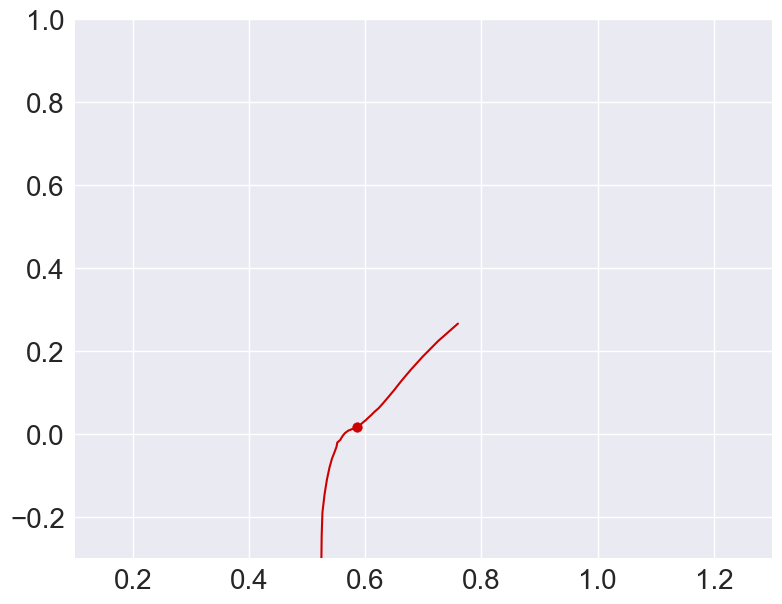

17 1.1845 Hz
Rmin:  0,0005864
m:  -1,5121846536976828
b:  0,0008758204242180822


In [181]:

cell="60Ah_cell3_neu"
t="45grad"
soc1=3
soc2=list(data[cell][t].keys())[soc1]
#---------
tief=17
#---------
params, cov = curve_fit(linear_func,data[cell][t][soc2][:int(tief/2),2],data[cell][t][soc2][:int(tief/2),3])
# params, cov = curve_fit(linear_func,data[cell][t][soc2][:int(tief/4),2],data[cell][t][soc2][:int(tief/4),3])

m, b = params
plt.plot(data[cell][t][soc2][:,2]*1000, -data[cell][t][soc2][:,3]*1000, label=soc2)
plt.scatter(data[cell][t][soc2][tief,2]*1000, -data[cell][t][soc2][tief,3]*1000)
# plt.plot(data[cell][t][soc2][:,2]*1000,-linear_func(data[cell][t][soc2][:,2],m,b)*1000, label="Fit")
# plt.plot(data[cell][t][soc2][:,2]*1000,-linear_func(data[cell][t][soc2][:,2],save_data[cell][t]["m"].iloc[soc1],save_data[cell][t]["b"].iloc[soc1])*1000, label="Fit" )
plt.xlim(0.1,1.3)
plt.ylim(-0.3,1)
plt.show()
print(tief,data[cell][t][soc2][tief,1],"Hz")
print("Rmin: ",str(data[cell][t][soc2][tief,2]).replace(".", ","))
print("m: ",str(m).replace(".", ","))
print("b: ",str(b).replace(".", ","))